# SLU16 - Data Sufficiency and Selection
### Exercise notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from utils import plot_learning_curve
import inspect

from hashlib import sha1 # just for grading purposes
import json

def _hash(obj):
    if type(obj) is not str:
        obj = json.dumps(obj)
    return sha1(obj.encode()).hexdigest()

# Context 
As you've learned, it's very important that the data scientist has a good domain knowledge of the field where they are working in, so that they can recognize unexpected effects, and can use their world model to chose features. 

So... to make sure we're all on the same level going into the exercises, we're going to be distinguishing between young and adult Abalones. 

What are Abalones, you ask? These cool things: 
![](https://nnimgt-a.akamaihd.net/transform/v1/crop/frm/Jesinta.Burton/30bc51dc-c571-4944-8dff-a7b5d0c14ff4.jpg/r0_0_728_409_w1200_h678_fmax.jpg)

For reasons which are frankly beyond me, there are people who know a lot about detecting the age of abalones. 

You will do this with machine learning. 

To make matters worse, your instructor is evil, and has added nonsensical random features. 

### Data
The target is `adult`, and is 0 when the abalone is a child, 1 when it's an adult. 

In [2]:
df = pd.read_csv('data/abalone.csv')
df = pd.get_dummies(df)
df.head(2)

,adult,Viscera weight,Coarse-grained Hormones,Diameter,Length,Phosphorylation,Ectopic relationships,Height,Whole weight,Shell weight,Shucked weight,Sex_F,Sex_I,Sex_M
0,1.0,0.1010,0.470,0.365,0.455,0.073,0.989,0.095,0.5140,0.15,0.2245,0,0,1
1,0.0,0.0485,0.697,0.265,0.350,0.655,0.119,0.090,0.2255,0.07,0.0995,0,0,1



# Exercise 1 - find the nonsense 

There are 3 features which are just random. Without using any model, find out which ones they are. 

To determine this use
1. pearson correlation 
2. mutual information (`mutual_info_classif`)

We don't really care about the intermediate steps, but you should probably visualize these in whatever way you like.  

_Hint #1: you can use `display(<something>)` if you want to force jupyter to display a series_  

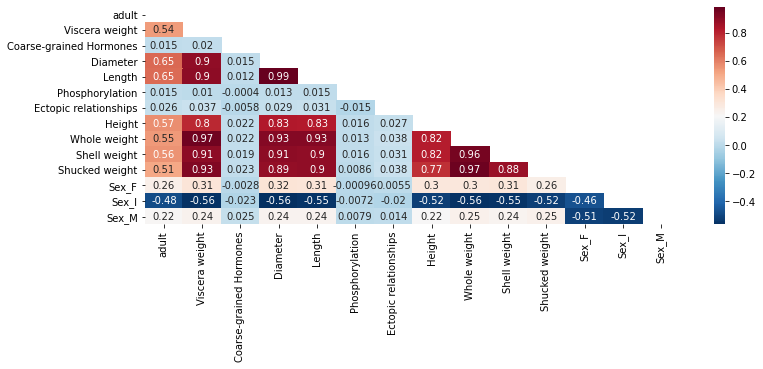

In [65]:
# X = ... 
# y = ... 

features = ['Viscera weight', 'Coarse-grained Hormones', 'Diameter',
       'Length', 'Phosphorylation', 'Ectopic relationships', 'Height',
       'Whole weight', 'Shell weight', 'Shucked weight', 'Sex_F', 'Sex_I',
       'Sex_M']
X = pd.get_dummies(df[features]).fillna(0)
y = df['adult']

# pearson_corr = ...
# something something 

# mutual_info = ... 
# something something 

# nonsense_features = [first, second, third]  (feature names only, the order does not matter)

# YOUR CODE HERE

import seaborn as sns 

pearson_corr =  df.corr(method='pearson')

lower_triangle_mask = np.triu(np.ones(pearson_corr.shape)).astype(np.bool)
cor_mat_lower = pearson_corr.mask(lower_triangle_mask)

plt.figure(figsize = (12,4)) # <-- just sets the figure size 

sns.heatmap(cor_mat_lower, 
            annot=True,     # <-- write the numbers on the squares
            cmap='RdBu_r'); #



#from sklearn.feature_selection import mutual_info_classif

#numerical = df.drop(categoricals, axis=1).columns
#numerical = numerical.drop('adult')

#mutual_info = mutual_info_classif(
#    X=df[numerical].fillna(0),  # as with so much in scikit, it does not like missing data
#    y=df['adult'])

#numerical_mutual_info = pd.Series(mutual_info, index=numerical).sort_values()
#numerical_mutual_info

nonsense_features = ['Coarse-grained Hormones','Phosphorylation','Ectopic relationships']

In [66]:
### BEGIN TESTS
assert _hash(sorted(nonsense_features)) == '1f2779dbe1c037234cba7a7f7f303bee81757cc1'
print('Great success!')
### END TESTS

Great success!


# Exercise 2 - observe the tree 

Yay! Time to look at trees. 

To pass this exercise, you will make a function called `train_and_plot_tree` that will do the following: 

1. Fit a tree with `max_depth` of 3, and `min_samples_split` of 20 
2. Plot that tree, in a way that clearly shows the feature names, and the percentage of adults in each node. 
3. Return the plot (just assign the output of a function to a variable and return it for evaluation) 

In [76]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

def train_and_plot_tree(X, y): 

# YOUR CODE HERE
    dt = DecisionTreeClassifier(max_depth=3, 
                            min_samples_split=20  # can also be number of samples
                           )
    dt.fit(X, y);
    
    plt.subplots(figsize=(20, 10))  # this helps you control the figure size 

    my_plot = plot_tree(
        decision_tree=dt,
        feature_names=X.columns,           # feature names to label the nodes 
        class_names=['child','adults'],  # what labels to place when the target is 0 or 1
        label='all',        
        filled=True,        # colors the squares 
        impurity=True,      
        proportion=True,    # show the fraction instead of number of examples  
        rounded=True,       # just cosmetic 
        fontsize=12);


    return my_plot 


In [77]:
sig = inspect.signature(train_and_plot_tree)
assert set(sig.parameters.keys()) == {'X', 'y'}, 'Do not change the signature!'  
all_text = ''.join([tree_plot[i].get_text() for i in range(len(tree_plot))])
assert 'Shell weight' in all_text, 'Your feature names seem weird'
assert 'child' in all_text, 'Did you make the right labels for class names?'
first_node_feature = tree_plot[0].get_text().split('<')[0].strip()
assert _hash(first_node_feature) == 'a0a91ccd0f0074dd419b7750263b9fbe107e7c86', 'Unexpected first node'
assert len(tree_plot) == 15, 'The tree seems to have the wrong size'
node_12 = tree_plot[12].get_text()
assert 'gini = 0.028' in node_12, 'Are you sure you configured the tree correctly?'
assert 'adult' in node_12, 'We want you to have the target labels in the plot'
assert '0.986' in node_12, 'Do you have the proportions in the nodes?'
print('Great success!')

Great success!


# Exercise 3: model based feature importances (linear) 
You will fit a logistic regression to get the features that produce the top 5 coefficients. 
Note that the coefficients can be both positive and negative, and you care about "the biggest magnitude". 

We will take care of the normalization for you. _(if you ever train a logistic regression without normalizing the features I will place gummybears in your lasagna. Consider yourself warned.)_

In [147]:
rs = RobustScaler()  # just scaling, because I'm nice. 
X_normed = pd.DataFrame(rs.fit_transform(X), 
                        columns=X.columns)  # remember this? cool huh! 


# As before, we just want the names of the features, in a list. 
# From now it's up to you. Use default parameters on the logistic regression. 
# something (~ 5 rows) 
# top_5_by_magnitude_linear = ... 

# YOUR CODE HERE


clf_log = LogisticRegression()
clf_log.fit(X_normed, y);
#print(clf_log.coef_)


#sfm = SelectFromModel(clf_log, prefit=True, max_features=5)

#top_5_by_magnitude_linear = X_normed.columns[sfm.get_support()]

coefs=clf_log.coef_[0]

coefs= np.absolute(coefs)

top_five = np.argpartition(coefs, -5)[-5:]

top_5_by_magnitude_linear=(X_normed.columns[top_five])


In [148]:
assert len(top_5_by_magnitude_linear) == 5 
assert _hash(sorted(top_5_by_magnitude_linear)) == 'f814d06f92beab782a3d1e0d0d9fe3098520c2b2'
print('Great success!')

Great success!


# Exercise 4: model based feature importances (non-linear) 
Oh, you made it! Good. Now for non-linear. 

Train a Random Forest, with the following parameters: 
* n_estimators = 50 
* max_depth = 2
* min_samples_split = 50 
* random_state = 1000
* n_jobs = -1  (optional, but speeds things up)

Then use it to get feature importances. Use the non-normalized features. 

As before, get the top 5 features by importance.

In [ ]:
# rf = ... 

# something (~5 rows)

# top_5_by_importance_random_forest = ...
# YOUR CODE HERE

rf = 

top_5_by_importance_random_forest = ...

print(sorted(top_5_by_importance_random_forest))

In [ ]:
assert len(top_5_by_importance_random_forest) == 5
assert _hash(sorted(top_5_by_importance_random_forest)) == 'bbc12adaef06b61e02cb766182fab945577633b4'
print('Great success!')

# Exercise 5: 

Do we have enough data, or should we go collect more abalones? Let's find out with learning curves! 

Using the random forest you already initialized, do the following: 

1. Define a numpy array of train_sizes, from 10% of the data to 100%, in increments of 10% (0.1, 0.2, 0.3... etc) 


2. Get the learning curve data, with the following configuration:
    - classifier: your old random forest from exercise 4 
    - metric: use area under the roc curve as your metric 
    - use the train sizes array you just created
    - all features, not normalized 
    - cv = 5 
    - random state = 1000 (needed to pass the grader) 
    - n_jobs = -1 (optional, but faster) 

As with the learning notebooks you should save the output to `train_sizes_abs`, `train_scores` and `test_scores` 

3. Plot it! _(feel free to use plot_learning_curve that we used in the learning notebook, but remember that's custom code)_ 


In [ ]:
# train_sizes = ...   (10% increments, starting at 10%)
# train_sizes_abs, train_scores, test_scores (get the data, no plotting here)

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
e1 = 'your train scores dont look right. Did you use the right features? Maybe check for categoricals, that can cause issues'
assert np.nan not in train_scores, e1 
assert train_sizes.sum() == 5.5, 'Are your train sizes correct?'
assert train_sizes.mean() == .55, 'Are your train sizes correct?'
assert len(train_sizes) == 10, 'Are your train sizes correct?'
assert train_sizes_abs.mean() == 1837.1, 'Are your train sizes abs correct?'
assert round(pd.DataFrame(train_scores).mean().median(), 2) == 0.94, 'Are your train scores correct?'
assert round(pd.DataFrame(test_scores).median().quantile(.3), 2) == 0.93, 'Are your test scores correct?'
print('Great success!')